In [267]:
#Importing the required libraries:

import json
import requests
import csv

# Step 1: Data Gathering

Set API endpoints for the Pagecounts API and the Pageviews API

Set Parameters to make the 'Pagecounts' and 'Pageviews' API calls

Make Pagecount and Pageview API calls to get mobile, desktop and both Wikipedia traffic data. The output is json file which is saved on disk.


In [268]:
# Declare constants

# Declare all endpoints
endpoint_legacy = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'
endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

# Parameter to call legacy Pagecounts API:
params_legacy_pagecounts={"project" : "en.wikipedia.org",
                         "access-site" : "desktop-site",
                         "granularity" : "monthly",
                         "start" : "2008010100",
                         "end" : "2016080100"}
params_legacy_pagecounts={"project" : "en.wikipedia.org",
                         "access-site" : "mobile-site",
                        "granularity" : "monthly",
                        "start" : "2008010100",
                        "end" : "2016080100"}

#Parameter to call Pageviews API:
params_pageviews={"project" : "en.wikipedia.org",
                  "access" : "desktop",
                  "agent" : "user",
                  "granularity" : "monthly",
                  "start" : "2015070100",
                  "end" : "2020080100"}

params_pageviews={"project" : "en.wikipedia.org",
                 "access" : "mobile-app",
                 "agent" : "user",
                 "granularity" : "monthly",
                 "start" : "2015070100",
                 "end" : "2020080100"}

params_pageviews={"project" : "en.wikipedia.org",
                  "access" : "mobile-web",
                  "agent" : "user",
                  "granularity" : "monthly",
                  "start" : "2015070100",
                  "end" : "2020080100"}

#headers for the API calls:
headers = {'user-Agent': 'https://github.com/sreejavm',
          'From' : 'sreejavm@uw.edu'}

In [269]:
#Function to fetch the data :
def api_call(endpoint,parameters):
    call=requests.get(endpoint.format(**parameters), headers=headers)
    response = call.json()
    
    return response

In [270]:
#collecting data for legacy_pagecounts and saving it in JSON file format:
legacy_pagecounts_desktop_site=api_call(endpoint_legacy,params_legacy_pagecounts)
with open('pagecounts_desktop-site_200801-201607.json', 'w') as json_file:
       json.dump(legacy_pagecounts_desktop_site, json_file)
    
leagcy_pagecounts_mobile_site=api_call(endpoint_legacy,params_legacy_pagecounts)
with open('pagecounts_mobile-site_200801-201607.json', 'w') as json_file:
     json.dump(leagcy_pagecounts_mobile_site, json_file) 

#collecting data for the pageviews and saving it in JSON file format:

pageviews_desktop=api_call(endpoint_pageviews,params_pageviews)
with open('pageviews_desktop_201507-202008.json', 'w') as json_file:
     json.dump(pageviews_desktop, json_file)
    
pageviews_mobile_app=api_call(endpoint_pageviews,params_pageviews)
with open('pageviews_mobile-app_201507-202008.json', 'w') as json_file:
     json.dump(pageviews_mobile_app, json_file)
    
pageviews_mobile_web=api_call(endpoint_pageviews,params_pageviews)
with open('pageviews_mobile-web_201507-202008.json', 'w') as json_file:
     json.dump(pageviews_mobile_web, json_file)

# Step 2: Data Processing

Load data from json response into the respective list for time, mobile, desktop and all site views/counts

Write the lists in a single dataframe for pagecount and pageviews

Merge the pagecount and pageviews dataframe into a single dataframe

Write the dataframe in a csv file and save it to disk

## 1. Combined mobile-web and mobile-app TotalViewsCount

In [271]:
# Combined_data_mobile -> stored timestamp as key and totalViewsCount as value
combined_data = {}
for entry in pageviews_mobile_web['items']:
    timestamp = entry['timestamp'][:6]
    entry['access'] = 'pageview_mobile_views'
    combined_data[timestamp] = {entry['access'] : entry['views']}
    

In [272]:
for entry in pageviews_mobile_app['items']:
    timestamp = entry['timestamp'][:6]
    entry['access'] = 'pageview_mobile_views'
    if timestamp in combined_data:
        combined_data[timestamp][entry['access']] = entry['views'] + combined_data[timestamp][entry['access']]
    else:
        entry['access'] = 'mobile-combined'
        combined_data[timestamp][entry['access']] = entry['views']
        

In [273]:
for entry in pageviews_desktop['items']:
    timestamp = entry['timestamp'][:6]
    combined_data[timestamp]['pageview_desktop_views'] = entry['views']

In [274]:
for entry in legacy_pagecounts_desktop_site['items']:
    timestamp = entry['timestamp'][:6]
    combined_data[timestamp] = {'pagecount_desktop_views' : entry['count']}

In [275]:
for entry in leagcy_pagecounts_mobile_site['items']:
    timestamp = entry['timestamp'][:6]
    if timestamp not in timestamp:
        combined_data[timestamp] = {}
    combined_data[timestamp]['pagecount_mobile_views'] = entry['count']

In [306]:
# combined_data

In [307]:
csv_data_with_header = list();
csv_data_with_header = [['year', 'month', 'pagecount_all_views', 'pagecount_desktop_views', 'pagecount_mobile_views', 'pageview_all_views', 'pageview_desktop_views', 'pageview_mobile_views']]

In [322]:
for timestamp, data in combined_data.items():
    row = list()
    row.append(timestamp[:4])
    row.append(timestamp[4:6])
    
    row.append(data['pagecount_desktop_views'] if 'pagecount_desktop_views' in data else 0 
               + data['pagecount_mobile_views']  if 'pagecount_mobile_views' in data else 0)
    row.append(data['pagecount_desktop_views'] if 'pagecount_desktop_views' in data else 0)
    row.append(data['pagecount_mobile_views'] if 'pagecount_mobile_views' in data else 0)
    
    row.append(data['pageview_desktop_views'] if 'pageview_desktop_views' in data else 0 
               + data['pageview_mobile_views'] if 'pageview_mobile_views' in data else 0 )
    row.append(data['pageview_desktop_views'] if 'pageview_desktop_views' in data else 0)
    row.append(data['pageview_mobile_views'] if 'pageview_mobile_views' in data else 0)
#     print(data['pageview_mobile_views'] if 'pageview_mobile_views' in data else 0)
#     print(row[5], ":", row[6], ":", row[7])
    csv_data_with_header.append(row)
    

In [323]:
with open('en-wikipedia_traffic_200712-202008.csv', 'w', newline='') as csv_file:
    wr = csv.writer(csv_file, quoting=csv.QUOTE_ALL)
    wr.writerows(csv_data_with_header)

# Step 3: Analyze the data

Create a plot to visualize Wikipedia traffic data Visualize Wikipedia traffic with 3 metrics: mobile traffic(for counts and views), desktop traffic(for counts and views) and all traffic (mobile + desktop)

Save the visualization as an image file


In [324]:
import pandas as pd
from matplotlib import pyplot as plt

In [325]:
df = pd.DataFrame(csv_data_with_header[1:])
df.columns = csv_data_with_header[0]
df['date'] = pd.to_datetime(df['year'].map(str)+ '-' + df['month'].map(str), format='%Y-%m')
df = df.sort_values(by="date")
df.head()


,year,month,pagecount_all_views,pagecount_desktop_views,pagecount_mobile_views,pageview_all_views,pageview_desktop_views,pageview_mobile_views,date
61,2014,10,3091546685,3091546685,3091546685,0,0,0,2014-10-01
131,2014,10,3091546685,3091546685,3091546685,0,0,0,2014-10-01
201,2014,10,3091546685,3091546685,3091546685,0,0,0,2014-10-01
132,2014,11,3027489668,3027489668,3027489668,0,0,0,2014-11-01
202,2014,11,3027489668,3027489668,3027489668,0,0,0,2014-11-01


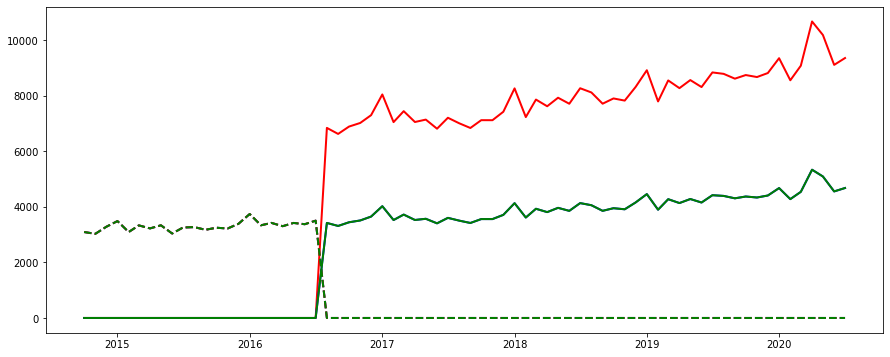

In [329]:
fig, ax = plt.subplots(figsize=(15,6))
n = int(len(df)/2)

ax.plot(df[['date']], df[['pagecount_desktop_views']]/1000000, color='blue', linewidth=2, label='pagecount_desktop_views',linestyle='dashed')
ax.plot(df[['date']], df[['pagecount_mobile_views']]/1000000, color='red', linewidth=2, label='pagecount_mobile_views',linestyle='dashed')
ax.plot(df[['date']], df[['pageview_mobile_views']]/1000000, color='red', linewidth=2,label='pageview_mobile_views')
ax.plot(df[['date']], df[['pageview_desktop_views']]/1000000, color='blue', linewidth=2,label='pageview_desktop_views')
ax.plot(df[['date']], df[['pageview_all_views']]/1000000, color='green', linewidth=2,label='pageview_all_views')
ax.plot(df[['date']], df[['pagecount_all_views']]/1000000, color='green', linewidth=2,label='pagecount_all_views', linestyle='dashed')
